In [1]:
import numpy as np
from mpnet.sst_envs.utils import load_data, get_obs
import pickle
import time
import click
from tqdm.auto import tqdm
from pathlib import Path
import importlib
from matplotlib import pyplot as plt

import sys
sys.path.append('/media/arclabdl1/HD1/Linjun/mpc-mpnet-py/deps/sparse_rrt-1')
from sparse_rrt import _deep_smp_module
from tqdm.notebook import tqdm


In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_line_3d(ax, p, p_index, color='b', alpha=1):
    for p_i in p_index:
        ax.plot3D(p[p_i, 0], p[p_i, 1], p[p_i, 2], c=color, alpha=alpha)

def centered_box_to_points_3d(center, size):
    half_size = [s/2 for s in size]
    direction, p = [1, -1], []
    for x_d in direction:
        for y_d in direction:
            for z_d in direction:
                p.append([center[di] + [x_d, y_d, z_d][di] * half_size[0] for di in range(3)])
    return p

def rot_frame_3d(state):
    frame_size = 0.25
    b, c, d, a = state[3:7]
    rot_mat = np.array([[2 * a**2 - 1 + 2 * b**2, 2 * b * c + 2 * a * d, 2 * b * d - 2 * a * c],
                        [2 * b * c - 2 * a * d, 2 * a**2 - 1 + 2 * c**2, 2 * c * d + 2 * a * b],
                        [2 * b * d + 2 * a * c, 2 * c * d - 2 * a * b, 2 * a**2 - 1 + 2 * d**2]])
    quadrotor_frame = np.array([[frame_size, 0, 0],
                                 [0, frame_size, 0],
                                 [-frame_size, 0, 0],
                                 [0, -frame_size, 0]]).T
    quadrotor_frame = rot_mat @ quadrotor_frame + state[:3].reshape(-1, 1)
    return quadrotor_frame

def q_to_points_3d(state):
    quadrotor_frame = rot_frame_3d(state)   
    max_min, direction = [np.max(quadrotor_frame, axis=1), np.min(quadrotor_frame, axis=1)], [1, 0]
    p = []
    for x_d in direction:
        for y_d in direction:
            for z_d in direction:
                p.append([max_min[x_d][0], max_min[y_d][1], max_min[z_d][2]])
    return np.array(p)

def draw_box_3d(ax, p, color='b', alpha=1, surface_color='blue', linewidths=1, edgecolors='k'):
    index_lists = [[[0, 4], [4, 6], [6, 2], [2, 0], [0, 1], [1, 5], [5, 7], [7, 3], [3, 1], [1, 5]],
                  [[4, 5]],
                  [[6, 7]],
                  [[2, 3]]]
    for p_i in index_lists:
        draw_line_3d(ax, np.array(p), p_i, color=color, alpha=alpha)
    edges = [[p[e_i] for e_i in f_i] for f_i in [[0, 1, 5, 4],
                                                 [4, 5, 7, 6],
                                                 [6, 7, 3, 2],
                                                 [2, 0, 1, 3],
                                                 [2, 0, 4, 6],
                                                 [3, 1, 5, 7]]]
    faces = Poly3DCollection(edges, linewidths=linewidths, edgecolors=edgecolors)
    faces.set_facecolor(surface_color)
    faces.set_alpha(0.1)
    ax.add_collection3d(faces)

def visualize_quadrotor_path(path, draw_bbox=True):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    if path is not None:
        ax.scatter(path[:, 0], path[:, 1], path[:, 2], c='blue')
        ax.plot(path[:, 0], path[:, 1], path[:, 2], c='blue')
        ax.scatter(start_state[0], start_state[1], start_state[2], c='red')
        ax.scatter(goal_state[0], goal_state[1], goal_state[2], c='orange')
        for waypoint in path:
            f = rot_frame_3d(waypoint)
            ax.scatter(f[0], f[1], f[2], color='red', s=10)
            ax.plot(f[0,[0, 2]], f[1, [0, 2]], f[2, [0, 2]], c='b')
            ax.plot(f[0,[1, 3]], f[1, [1, 3]], f[2, [1, 3]], c='b')

            if draw_bbox:
                draw_box_3d(ax, q_to_points_3d(waypoint), alpha=0.3, surface_color="orange", linewidths=0.)
    for obs in obs_list:
        draw_box_3d(ax, centered_box_to_points_3d(center=obs, size=[params['width']]*3))

    ax.set_xlim3d(-5, 5)
    ax.set_ylim3d(-5, 5)
    ax.set_zlim3d(-5, 5)
    return fig, ax

def plan(start_state, goal_state, params, obs_list):
    system = "quadrotor_obs"
    planner = _deep_smp_module.DSSTMPCWrapper(
            system,
            start_state=start_state,
            goal_state=goal_state,
            goal_radius=params['goal_radius'],
            random_seed=0,
            sst_delta_near=params['sst_delta_near'],
            sst_delta_drain=params['sst_delta_drain'],
            obs_list=obs_list,
            width=params['width'],
            integration_step=params['dt'], 
        )
    for i in range(params['number_of_iterations']):
        start, end = planner.steer_sst(params['min_time_steps'], params['max_time_steps'], params['dt'])
        if i % 10000 == 0:
            solution = planner.get_solution()
            print(i, solution[2].sum() if solution is not None else np.inf)
            if solution is not None:
                break
    return solution
start_state = np.array([0, 0, 0,
                        0, 0, 0, 1,
                        0, 0, 0,
                        0, 0, 0])
goal_state = np.array([3, 3, -4,
                       0, 0, 0, 1,
                       0, 0, 0,
                       0, 0, 0])
obs_list = np.array([[2, 2, 2], [1, 3, 4]])
params = {"dt": 2e-2,
          "goal_radius": 2,
          "sst_delta_near": .5,
          "sst_delta_drain": .1,
          "width": 1,        
          "min_time_steps": 1,
          "max_time_steps": 30,
          "number_of_iterations": 600000}

In [3]:
solution = plan(start_state, goal_state, params, obs_list)

0 inf
10000 inf
20000 inf
30000 4.460000000000001


<IPython.core.display.Javascript object>


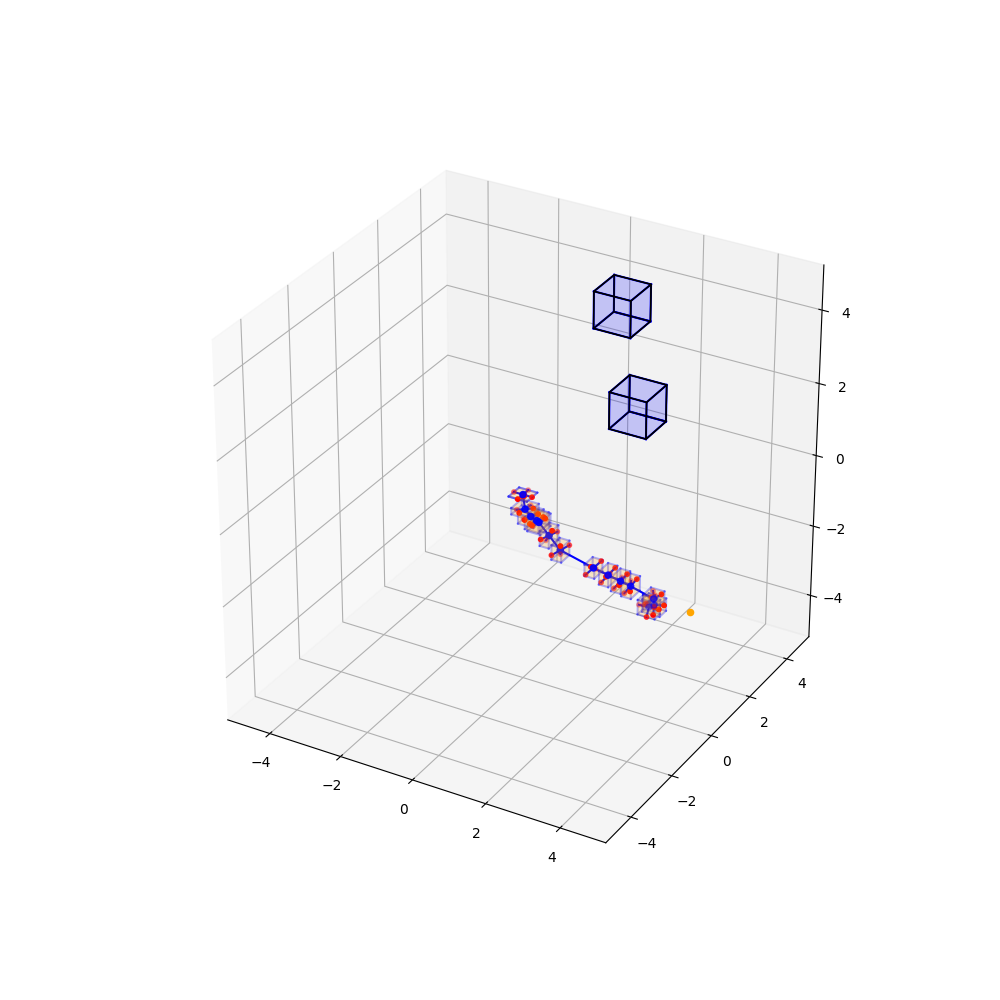

(<Figure size 1000x1000 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fdca6b69040>)

In [4]:
%matplotlib notebook
path = solution[0] if solution is not None else None
visualize_quadrotor_path(path)


In [9]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# draw_box(ax, centered_box_to_points(center=[0,0,0], size=[params['width']]*3))
# draw_box(ax, q_to_points(start_state), color='orange')

# PostPropagate

In [5]:
from mpnet.sst_envs.systems.quadrotor import QuadrotorVec
def post_propagate(start_state, solution, dt=2e-2, interp_freq=1):
    assert solution is not None
    system = QuadrotorVec()
    post_state = start_state.copy().astype(np.float)
    post_propagate_path = [post_state.copy()]
    counter = 0
    for i in range(solution[1].shape[0]):
        num_steps = int(solution[2][i] / 2e-2)
        for step in range(num_steps):
            post_state = system.propagate(post_state,
                                          solution[1][i],
                                          1,
                                          dt)
            counter += 1
            if counter % interp_freq == 0:
                counter = 0
                post_propagate_path.append(post_state.copy())
    return np.array(post_propagate_path)

p_path = post_propagate(start_state, solution, interp_freq=10)

<IPython.core.display.Javascript object>


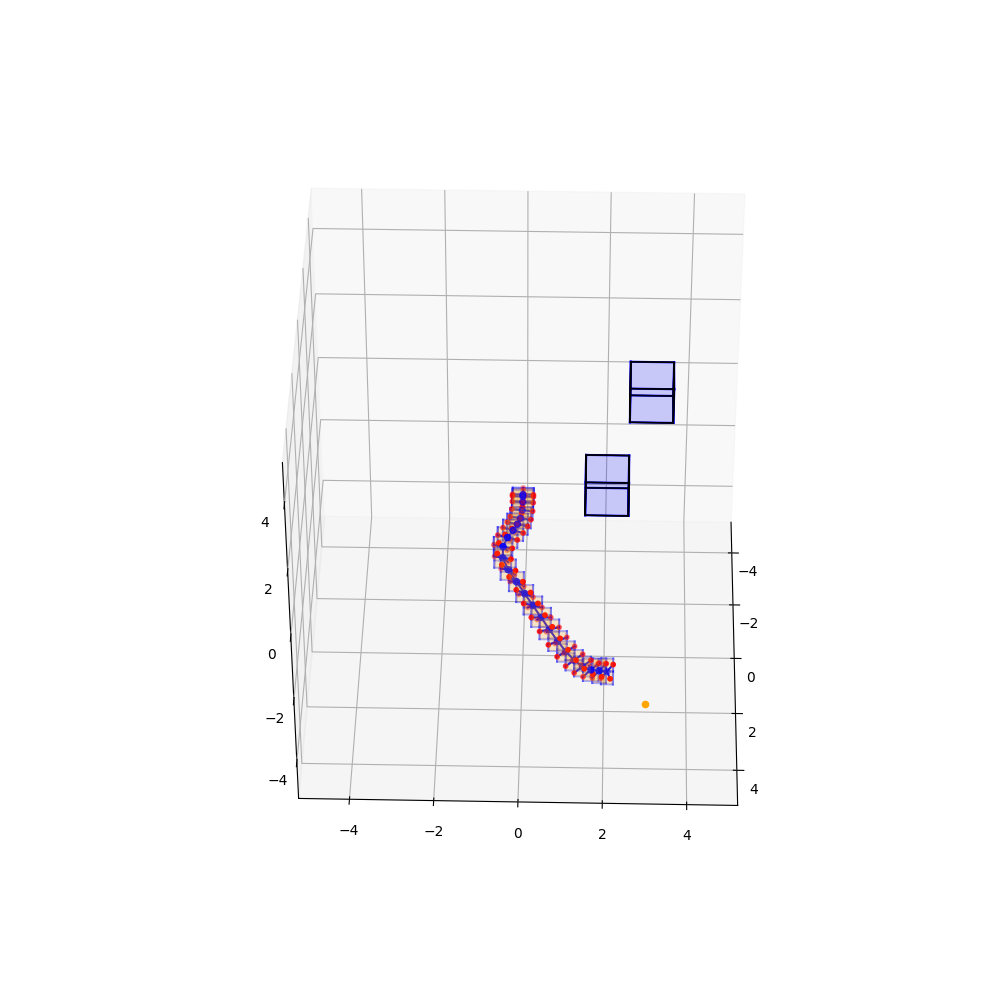

(<Figure size 1000x1000 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fdc937f8d00>)

In [6]:
visualize_quadrotor_path(p_path)